<a href="https://colab.research.google.com/github/tsangrebecca/BloomTech/blob/main/Sprint5/DS_Sprint_Challenge_21.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

BloomTech Data Science

*Unit 2, Sprint 1*

---

👇 **Do not change the code in this cell.** If you're working in Google Colab, you can run this cell to install `category_encoders`.

In [1]:
%%capture
# If you're in Colab...
import sys
if 'google.colab' in sys.modules:
    !pip install category_encoders==2.*


# Sprint Challenge: Predicting Home Prices in Iowa 🏠

The goal of this assignment is to build a regression model that can predict the sale price of a house in Aimes, Iowa.

# Directions

This notebook contains 12 tasks, which cover the material we've learned in this sprint. Here's a summary:

- **Task 1:** Import training data.
- **Task 2 (`stretch goal`):** Create scatter plot.
- **Task 3:** Split data into feature matrix and target vector.
- **Task 4:** Split data into training and validation sets.
- **Task 5:** Establish baseline mean absolute error.
- **Task 6:** Build and train linear regression model.
- **Task 7:** Build and train ridge regression model.
- **Task 8:** Calculate mean absolute error for training and validation sets.
- **Task 9:** Calculate $R^2$ for validation set.
- **Task 10:** Make predictions based on test set.
- **Task 11 (`stretch goal`):** Get below 18,000 for test set MAE.
- **Task 12 (`stretch goal`):** Plot model coefficients.

For each task you should do the following:

- Read the task instructions.
- Write your code in the cell below the task. Delete the `raise NotImplementedError` before your start.
- Run the testing cell below the task. If you get an error, read the error message and re-evaluate your code.

**You should limit your code to the following libraries:**

- `category_encoders`
- `numpy`
- `matplotlib`
- `pandas`
- `sklearn`

# Tasks

## I. Wrangle Data

**Task 1:** Since real estate prices fluctuate over time, it's important to index the houses in this dataset using the year in which they were sold. First, load the dataset into a DataFrame named `df` and find the column that states the year sold. Next, modify the code below so that `Yr_Sold` column is parsed as a datetime object and set as the index.

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from category_encoders import OneHotEncoder

In [4]:
'''T1: Import data into DataFrame `df`.'''
# import pandas as pd

url_train = 'https://drive.google.com/uc?export=download&id=1tmYLQ1RwIgjI_d66PWnlXU-5D_VxtiQc'
df = pd.read_csv(url_train,
                 parse_dates=['Yr_Sold'],
                 index_col='Yr_Sold')
# YOUR CODE HERE


**Task 1 Testing**

In [5]:
'''T1 Testing.'''
assert isinstance(df, pd.DataFrame), '`df` is not a DataFrame. Did you import the data?'
assert len(df) == 2564, 'DataFrame `df` has the wrong number of rows.'
assert isinstance(df.index, pd.DatetimeIndex), '`df` does not have a datetime index.'

In [6]:
df.head()

,1st_Flr_SF,Bedroom_AbvGr,Bldg_Type,Bsmt_Full_Bath,Bsmt_Half_Bath,Central_Air,Condition_1,Condition_2,Electrical,Exter_Cond,Exter_Qual,Exterior_1st,Exterior_2nd,Foundation,Full_Bath,Functional,Gr_Liv_Area,Half_Bath,Heating,Heating_QC,House_Style,Kitchen_AbvGr,Kitchen_Qual,Land_Contour,Land_Slope,Lot_Area,Lot_Config,Lot_Shape,MS_SubClass,MS_Zoning,Mas_Vnr_Type,Mo_Sold,Neighborhood,Overall_Cond,Overall_Qual,Paved_Drive,Roof_Matl,Roof_Style,SalePrice,Sale_Condition,Sale_Type,Street,TotRms_AbvGrd,Utilities,Year_Built,Year_Remod/Add
Yr_Sold,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2009-01-01,882,2,1Fam,0.0,0.0,Y,Norm,Norm,SBrkr,TA,TA,MetalSd,MetalSd,CBlock,1,Typ,882,0,GasA,TA,1Story,1,TA,Lvl,Gtl,13008,Inside,IR1,20,RL,None,10,NAmes,5,6,Y,CompShg,Gable,124500,Normal,WD,Pave,5,AllPub,1956,1956
2009-01-01,1434,4,1Fam,1.0,0.0,Y,Norm,Norm,SBrkr,TA,TA,Plywood,Plywood,CBlock,2,Typ,1434,0,GasA,TA,1Story,1,TA,Lvl,Gtl,10200,Inside,Reg,20,RL,BrkFace,6,NAmes,5,6,Y,CompShg,Hip,157000,Normal,WD,Pave,7,AllPub,1974,1974
2009-01-01,2000,4,1Fam,1.0,0.0,Y,Norm,Norm,SBrkr,TA,Gd,Plywood,Wd Sdng,CBlock,2,Typ,2704,1,GasA,Gd,SLvl,1,Ex,Lvl,Gtl,13860,Inside,Reg,80,RL,None,7,NAmes,7,8,Y,CompShg,Gable,345000,Normal,WD,Pave,9,AllPub,1972,1995
2009-01-01,945,3,1Fam,0.0,0.0,Y,Norm,Norm,SBrkr,TA,TA,VinylSd,VinylSd,PConc,2,Typ,1608,1,GasA,Ex,2Story,1,TA,Lvl,Gtl,10179,Corner,IR1,60,RL,None,7,Gilbert,5,6,Y,CompShg,Gable,189500,Normal,WD,Pave,7,AllPub,1997,1997
2009-01-01,1008,4,1Fam,0.0,0.0,Y,Norm,Norm,SBrkr,TA,Gd,VinylSd,VinylSd,PConc,2,Typ,2283,1,GasA,Ex,2Story,1,Gd,Lvl,Gtl,11792,Inside,IR1,60,RL,BrkFace,8,Gilbert,5,8,Y,CompShg,Gable,270000,Normal,WD,Pave,9,AllPub,2003,2003


**Task 2 (`stretch goal`):** Create a scatter plot that shows `'SalePrice'` as a function of `'Gr_Liv_Area'`. Be sure to label the axes of your plot.

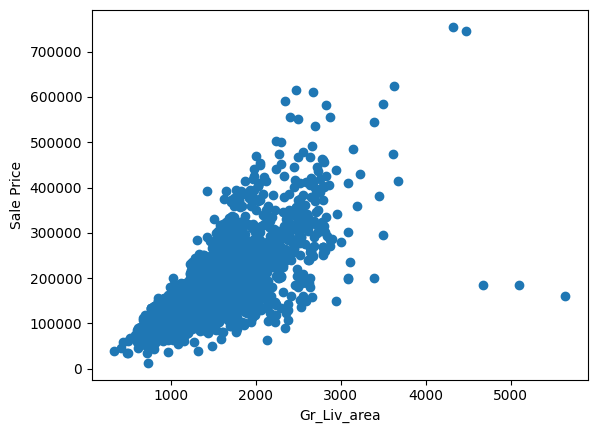

In [12]:
# import matplotlib.pyplot as plt

# YOUR CODE HERE
x = df['Gr_Liv_Area']
y = df['SalePrice']
plt.scatter(x, y)
plt.xlabel('Gr_Liv_area')
plt.ylabel('Sale Price')
plt.show()

## II. Split Data

**Task 3:** Since you're building a model to predict the price at which a house will be sold, your target is the `'SalePrice'` column. Split the DataFrame `df` into the target vector `y` and the feature matrix `X`.

In [13]:
'''T3: Split `df` into `X` and `y`.'''

target = 'SalePrice'
# YOUR CODE HERE
X = df.drop(columns=target)
y = df[target]

**Task 3 Testing**

In [14]:
'''T3 Tests'''
assert y.shape == (2564,), '`y` either has the wrong number of rows, or is two-dimentional.'
assert X.shape == (2564, 45), '`X` has the wrong number of columns or rows.'
assert 'SalePrice' not in X.columns, 'Target is still part of feature matrix.'

**Task 4:** Split `X` and `y` into training and validation sets. Since housing prices fluctuate over time, you should use the time-based cutoff method.

- Training: Homes sold before 2009
- Validation: Homes sold during 2009

In [15]:
'''T4: Split `X` and `y` into training, validation, and testing sets.'''

# YOUR CODE HERE
cutoff = '2009'
mask = X.index < cutoff
X_train, y_train = X.loc[mask], y.loc[mask]
X_val, y_val = X.loc[~mask], y.loc[~mask]

**Task 4 Testing**

In [17]:
'''T4 Tests'''
assert len(X_train) == len(y_train) == 1920, 'Your training set has the wrong number of rows.'
assert len(X_val) == len(y_val) == 644, 'Your validation set has the wrong number of rows.'

## III. Set Baseline

**Task 5:** Before you can create a model to predict sale price, you need to establish a baseline. First, calculate the mean housing price for your training set. Next, calculate the *mean absolute error* for a model that always predicts that mean. Be sure to assign the mean absolute error to a variable named `baseline_mae`.

In [18]:
'''T5: Calculate baseline mean absolute error.'''
from sklearn.metrics import mean_absolute_error

# YOUR CODE HERE
y_baseline_from_mean = [y_train.mean()] * len(y_train)
baseline_mae = mean_absolute_error(y_train, y_baseline_from_mean)
print('Baseline MAE:', baseline_mae)

Baseline MAE: 58502.9394639757


**Task 5 Testing**

In [19]:
'''T5 Tests'''
assert isinstance(baseline_mae, float), '`baseline_mae` is not a `float`. Have you assigned a value to this variable name?'

## IV. Build Models

**Task 6:** Build and train a linear regression model named `model_lr` that predicts home sale price. Your model should have the following components:

- A `OneHotEncoder` for categorical features.
- A `StandardScaler` so that you can compare your model coefficients after training.
- A `pipeline` that combines transformers and predictor.

**Tip:** For your `OneHotEncoder`, `use_cat_names` should be set to `True`.

In [23]:
'''T6: Build and train LinearRegression model.'''
# from sklearn.pipeline import make_pipeline
# from sklearn.linear_model import LinearRegression
# from category_encoders import OneHotEncoder
# from sklearn.preprocessing import StandardScaler

# YOUR CODE HERE

model_lr = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    StandardScaler(),
    LinearRegression()
)
model_lr.fit(X_train, y_train);

**Task 6 Testing**

In [24]:
'''T6 Tests'''
from sklearn.pipeline import Pipeline
assert isinstance(model_lr, Pipeline), '`model_lr` is not a pipeline.'
assert len(model_lr.named_steps) > 1, 'Your `model_lr` pipeline is missing components.'

**Task 7:** Build and train a ridge regression model named `model_r` that predicts home sales price. Your model should include the following components:

- A `OneHotEncoder` for categorical features.
- A `StandardScaler` so that you can compare your model coefficients after training.
- A `pipeline` that combines transformers and predictor.

**Tip:** For your `Ridge` model, the `alpha` parameter should be set to a value of your choosing. Read more about the `alpha` parameter [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html)

In [25]:
'''T7. Build and train Ridge model.'''
# from sklearn.linear_model import Ridge

# YOUR CODE HERE
model_r = make_pipeline(
    OneHotEncoder(use_cat_names=True),
    StandardScaler(),
    Ridge()  # by default alpha is 1.0
)
model_r.fit(X_train, y_train);

**Task 7 Testing**

In [26]:
assert isinstance(model_r, Pipeline), '`model_r` is not a pipeline.'
assert len(model_r.named_steps) > 1, 'Your `model_r` pipeline is missing components.'

## V. Check Metrics

**Task 8:** Compare your models by calculating their mean absolute error for the training and validation sets. You should assign these to the variables `model_lr_training_mae`, `model_lr_validation_mae`, `model_r_training_mae`, and `model_r_validation_mae`, respectively. The validation MAE for your Ridge model should be lower than your `baseline_mae`.

In [27]:
'''T8: Compare model metrics, MAE.'''
# YOUR CODE HERE
model_lr_training_mae = mean_absolute_error(y_train, model_lr.predict(X_train))
model_lr_validation_mae = mean_absolute_error(y_val, model_lr.predict(X_val))
model_r_training_mae = mean_absolute_error(y_train, model_r.predict(X_train))
model_r_validation_mae = mean_absolute_error(y_val, model_r.predict(X_val))
print('Linear Regression Model')
print('Training MAE:', model_lr_training_mae)
print('Validation MAE:', model_lr_validation_mae)
print()
print('Ridge Regression Model')
print('Training MAE:', model_r_training_mae)
print('Validation MAE:', model_r_validation_mae)

Linear Regression Model
Training MAE: 16329.35753972315
Validation MAE: 2575510468729479.0

Ridge Regression Model
Training MAE: 16119.822691743924
Validation MAE: 17986.919803129553


**Task 8 Testing**

In [28]:
'''T8 Tests'''
assert isinstance(model_lr_training_mae, float), '`model_lr_training_mae` is not a float. Did you assign a value to this variable?'
assert isinstance(model_lr_validation_mae, float), '`model_lr_validation_mae` is not a float. Did you assign a value to this variable?'
assert isinstance(model_r_training_mae, float), '`model_r_training_mae` is not a float. Did you assign a value to this variable?'
assert isinstance(model_r_validation_mae, float), '`model_r_validation_mae` is not a float. Did you assign a value to this variable?'

**Task 9:** Compare your two models by calculating their $R^2$ score for the **validation data**.

In [30]:
'''T9: Compare model metrics, R^2.'''
# YOUR CODE HERE
model_lr_r2_score = model_lr.score(X_val, y_val)
model_r_r2_score = model_r.score(X_val, y_val)
print('Linear Regression R^2:', model_lr_r2_score)
print('Ridge Regression R^2:', model_r_r2_score)

Linear Regression R^2: -4.54962587760736e+23
Ridge Regression R^2: 0.8887380165377932


**Task 9 Testing**

In [31]:
'''T9 Tests'''
assert isinstance(model_lr_r2_score, float), '`model_lr_r2_score` is not a float. Did you assign a value to this variable?'
assert isinstance(model_r_r2_score, float), '`model_r_r2_score` is not a float. Did you assign a value to this variable?'
assert model_lr_r2_score <= 1, 'The maximum value for an R^2 score is 1.'
assert model_r_r2_score <= 1, 'The maximum value for an R^2 score is 1.'

**Task 10:** Based on the metrics above, choose the best of your two models and generate an array of predictions `y_pred` using the test set below.

**Note:** Make sure that you import and clean the test set *exactly the same way* you did with the training set at the start of this notebook.

In [40]:
url_test = 'https://drive.google.com/uc?export=download&id=1y9u8cOWprTjruw8E-ct1c7YaEytToqd_'
X_test = pd.read_csv(url_test,
                 parse_dates=['Yr_Sold'],
                 index_col='Yr_Sold')

y_pred = model_r.predict(X_test)

# YOUR CODE HERE

print('My predictions:', y_pred[:3])

My predictions: [219431.82052472 104354.37322437 159396.82083221]


**Task 10 Testing:** There is a hidden test in the cell below. When you submit your notebook to Canvas, your test MAE will be calculated. In order to get the point for this task, your test MAE must be below 58,000.

**Tip:** Use your validation MAE to estimate what your test MAE will be.

In [42]:
# import numpy as np
assert isinstance(y_pred, np.ndarray), '`y_pred` should be type `ndarray`.'
assert y_pred.shape == (340,), '`y_pred` should be a 1-dimentional array with 340 predictions.'
# Your test MAE will be printed out below when you submit your assignment.

**Task 11 (`stretch goal`):** There's no code to write for this task. Below is another testing cell that will calculate the MAE for your test set. In order to get the point for this task, your test MAE must be below 18,000.

**Tip:** Are there any **hyperparameters** in your model that you could adjust to improve performance?

In [43]:
assert isinstance(y_pred, np.ndarray), '`y_pred` should be type `ndarray`.'
assert y_pred.shape == (340,), '`y_pred` should be a 1-dimentional array with 340 predictions.'
# Your test MAE will be printed out below when you submit your assignment.

In [44]:
y_pred.shape

(340,)

## VI. Explain Model

**Task 12 (`stretch goal`):** Create a horizontal barchart for your best performing model that shows the ten most important features for the model's predictions. Don't forget to label your axes!

This task will not be autograded - but it is part of completing the challenge.

/usr/local/lib/python3.10/dist-packages/category_encoders/utils.py:362: FutureWarning: `get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.
  warnings.warn("`get_feature_names` is deprecated in all of sklearn. Use `get_feature_names_out` instead.",


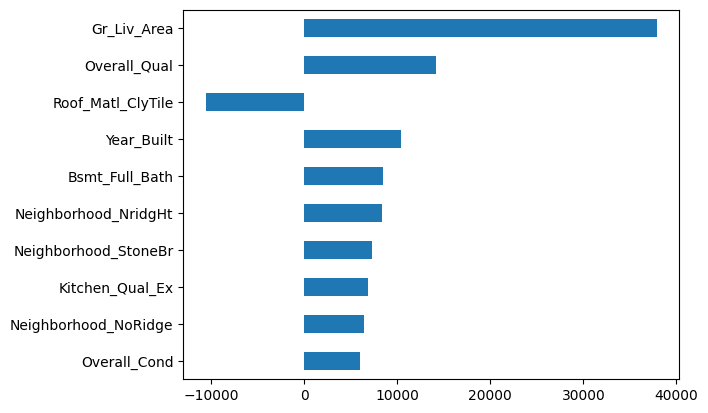

In [47]:
# YOUR CODE HERE
# with pipeline, we have to call the ridge stpe inside the pipeline using .name_steps method to access the coef_ and get_feature_names
coefficients = model_r.named_steps['ridge'].coef_
features = model_r.named_steps['onehotencoder'].get_feature_names()
feature_importance = pd.Series(coefficients, index=features).sort_values(key=abs)
feature_importance.tail(10).plot(kind='barh');